# WG - Gesucht Data Analysis 
#### Step 4: Price Determinanats Analysis

##### This notebook explores the data of the WG-Gesucht dataset. The process includes the following: 
- Determinants: RoomSize, District, Furnited, Rent Duration
- Creating Hypotheses for each determinant 
- Create a Linear Regression Model, plot the outcome 
- Show the Regression Results, Test the Hypothesis. 

#### Step 1: Preparation of the Dataset

In [276]:
import os 
from openpyxl import load_workbook
import pandas as pd
import src.style as st
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [277]:
import warnings 
warnings.filterwarnings('ignore')

In [278]:
df = pd.read_parquet('Data/apartmentsBerlinDataCleaned.parquet')

In [279]:
df_price_det_analysis = df[['apartmentID', 'title', 'room_size', 'total_rent', 'suburb', 'district', 'online_since' ,'available_from', 'available_until', 'apartment_size', 'furnitured', 'balcony', 'garden', 'bathroom']]

# Clean the data and convert the columns to the right data type for calculations
df_price_det_analysis.loc[:, 'room_size'] = df_price_det_analysis['room_size'].str.replace('m²', '').astype(float)
df_price_det_analysis.loc[:, 'apartment_size'] = df_price_det_analysis['apartment_size'].str.replace('m²', '').astype(float)
df_price_det_analysis.loc[:, 'total_rent'] = df_price_det_analysis['total_rent'].str.replace('€', '').astype(float)
df_price_det_analysis.loc[:, 'online_since'] = pd.to_datetime(df_price_det_analysis['online_since'])
df_price_det_analysis.loc[:, 'available_from'] = pd.to_datetime(df_price_det_analysis['available_from'], dayfirst=True)
df_price_det_analysis.loc[:, 'available_until'] = pd.to_datetime(df_price_det_analysis['available_until'], dayfirst=True)

In [280]:
df_price_det_analysis.loc[:, 'price_per_m2'] = df_price_det_analysis['total_rent'] / df_price_det_analysis['room_size']

#### Step 2: Create Hypothesis

1. Roomsize and square meter price  

    Hypothesis 1 (H1): There is a negative correlation between the size of the shared room and the square meter price, meaning that larger rooms tend to have a lower square meter price.

2. District and square meter price
    
    Hypothesis 2 (H2): The square meter price varies significantly between different districts in Berlin, with certain districts systematically having higher or lower prices than others.

3. Rental duration and square meter price
    
    Hypothesis 3 (H3): The rental duration has a significant impact on the square meter price, with shorter rental contracts (e.g., less than three months) leading to higher square meter prices than longer rental contracts.

4. Furnishing and square meter price

    Hypothesis 4 (H4): Apartments with better amenities (e.g., fully furnished, balcony, garden) have higher square meter prices compared to less well-equipped apartments.

#### Step 2.1: Roomsize and Square Meter Price 

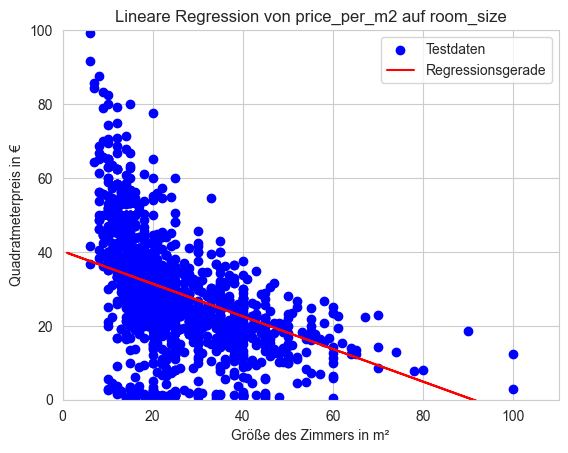

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     1096.
Date:                Tue, 16 Apr 2024   Prob (F-statistic):          9.72e-223
Time:                        15:40:56   Log-Likelihood:                -28206.
No. Observations:                6690   AIC:                         5.642e+04
Df Residuals:                    6688   BIC:                         5.643e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.1973      0.379    106.028      0.0

In [281]:
df = df_price_det_analysis.copy()

x = 'room_size'
y = 'price_per_m2'

df[x] = pd.to_numeric(df[x], errors='coerce')
df[y] = pd.to_numeric(df[y], errors='coerce')

df.dropna(subset=[x, y], inplace=True)

# Vorbereiten der Daten
X = df[x]
Y = df[y]
X = sm.add_constant(X)  # Fügt eine Konstante (Intercept) zum Modell hinzu

# Aufteilen der Daten in Trainings- und Testsätze
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Modell erstellen und anpassen mit statsmodels für detaillierte Statistiken
model = sm.OLS(y_train, X_train).fit()

# Modellbewertung auf Testdaten
y_pred = model.predict(X_test)
r_squared = model.rsquared

# Plot der Daten und der Regressionsgerade
plt.scatter(X_test[x], y_test, color='blue', label='Testdaten')
plt.plot(X_test[x], y_pred, color='red', label='Regressionsgerade')
plt.title('Lineare Regression von ' + y + ' auf ' + x)
plt.xlabel('Größe des Zimmers in m²')
plt.ylabel('Quadratmeterpreis in €')
plt.ylim(0, 100)
plt.xlim(0, 110)
plt.legend()
plt.show()

print(model.summary())


1. Coefficient of room_size
- Relevance: This coefficient (-0.4415) directly tests your hypothesis. It quantifies the change in the dependent variable price_per_m2 for each one-unit change in room_size.
- Interpretation: Since the coefficient is negative, it confirms the direction of the relationship as hypothesized: as room_size increases, price_per_m2 decreases.
- Significance: The t-statistic and its corresponding p-value (P>|t|) provide the significance of this relationship. In your output, the t-statistic for room_size is -33.109, and the p-value is close to 0. This indicates that the negative relationship between room_size and price_per_m2 is statistically significant, and therefore, we can reject the null hypothesis of no relationship.

2. R-squared and Adjusted R-squared
- Relevance: These statistics indicate how well the model fits the data, or how much variance in price_per_m2 is explained by room_size.
- Interpretation: An R-squared value of 0.141 suggests that 14.1% of the variability in price_per_m2 can be explained by the model, which is not very high, indicating a weak model fit overall.
- Use: This helps determine the model's explanatory power but does not affect the testing of the specific hypothesis about the direction and significance of the relationship.

3. F-statistic and Prob (F-statistic)
- Relevance: This tests whether at least one predictor variable in the model has a statistically significant relationship with the dependent variable.
- Interpretation: A very large F-statistic (1096) and a very small p-value (9.72e-223) suggest that the model as a whole is significant – meaning that the set of independent variables (in this case, just room_size) does significantly affect price_per_m2.

4. Durbin-Watson Statistic
- Relevance: Tests for autocorrelation in the residuals.
- Interpretation: A value near 2.0 (2.010 in your case) suggests there is no autocorrelation, which is good as autocorrelation can invalidate the model's standard errors, leading to misleading significance tests.

5. P>|t| for individual coefficients
- Relevance: Specifically tests the null hypothesis that each coefficient is equal to zero (no effect).
- Interpretation: The very small p-value for room_size implies a statistically significant effect, which is critical for confirming your hypothesis.

Conclusion:

The model's output supports your Hypothesis 1, demonstrating a significant negative relationship between the size of the room (room_size) and the square meter price (price_per_m2). However, the model explains only a small portion of the variance in square meter prices, suggesting that other factors may also be important. To further improve the model, consider including additional relevant variables or exploring potential non-linear relationships.

#### Step 2.2: District and square meter price

In [282]:
# Remove rows with missing 'district'
df_cleaned = df_price_det_analysis.dropna(subset=['district', 'price_per_m2'])

df_cleaned['price_per_m2'] = pd.to_numeric(df_price_det_analysis['price_per_m2'], errors='coerce')

# Generate dummy variables for 'district' again
district_dummies = pd.get_dummies(df_cleaned['district'], drop_first=True).astype(int)

# Prepare the regression variables
X = district_dummies
Y = df_cleaned['price_per_m2']

# Add a constant to the model (for the intercept)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=50)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.500
Date:                Tue, 16 Apr 2024   Prob (F-statistic):            0.00392
Time:                        15:40:57   Log-Likelihood:                -25239.
No. Observations:                5536   AIC:                         5.050e+04
Df Residuals:                    5524   BIC:                         5.058e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

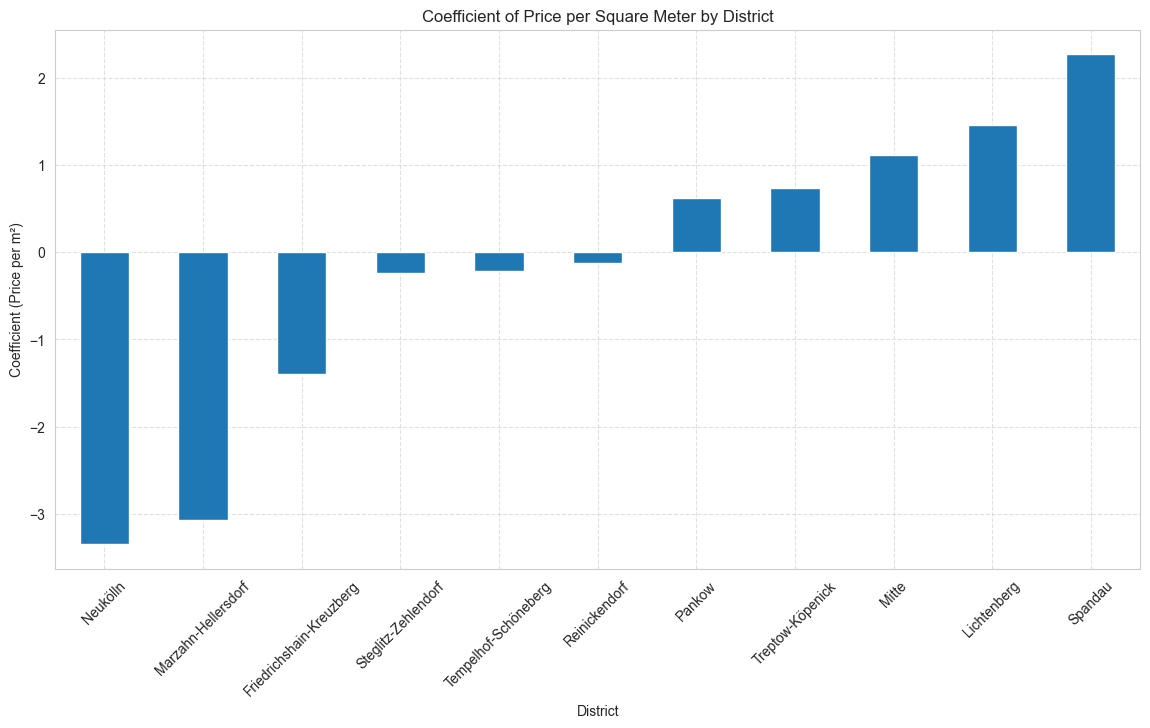

In [283]:
# Extract coefficients for districts and remove the constant
coef = model.params.drop('const')

# Create a bar plot for the coefficients
plt.figure(figsize=(14, 7))
coef.sort_values().plot(kind='bar')
plt.title('Coefficient of Price per Square Meter by District')
plt.xlabel('District')
plt.ylabel('Coefficient (Price per m²)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Hypothesis Evaluation:
Hypothesis (H2): "The square meter price varies significantly between different districts in Berlin, with certain districts systematically having higher or lower prices than others."

Analysis of Results:
- R-squared (0.005): This value is extremely low, indicating that only 0.5% of the variance in square meter prices is explained by the differences in districts according to your model. This suggests that other factors not included in the model may be influencing square meter prices much more significantly than the district alone.

- F-statistic (2.500) and its Probability (0.00392): The F-statistic is relatively low, but the probability is significant (p < 0.01), suggesting that there is statistically significant evidence that at least some district coefficients are non-zero. However, the overall influence of districts on price variation is weak.

- Coefficients: The coefficients for the districts indicate the relative difference in price per square meter compared to the baseline district (not shown because drop_first=True was used). For example:

    - Neukölln: The coefficient is -3.3439 with a statistically significant p-value (0.044), suggesting that prices in Neukölln are lower than the baseline district by about 3.344 euros per square meter.
    - Other districts like Friedrichshain-Kreuzberg, Lichtenberg, and Mitte show differences in price, but their p-values indicate that these differences are not statistically significant at conventional levels (p > 0.05), except for Neukölln.

Model Diagnostics:

- Durbin-Watson: The statistic is around 2, which suggests there is no serious autocorrelation in the residuals.
- Omnibus/Prob(Omnibus), Jarque-Bera/Prob(JB): Extremely high values indicating very significant deviations from normality in the residuals, likely due to outliers or a non-linear distribution in the dependent variable or errors.
- Skewness and Kurtosis: The high values indicate a highly skewed distribution with heavy tails, which can affect the reliability of the OLS estimates.

Conclusion:

While there is evidence that district location has some effect on square meter prices, the overall effect size is quite small, and the model itself does not robustly explain price variations across districts. The data may be subject to issues not captured in the model, such as non-linear relationships, omitted variables (like property conditions, proximity to amenities, public transport accessibility), or other socio-economic factors.



#### Step 2.3: Rental Duration and Square Meter Price 

In [284]:
df = df_price_det_analysis.copy()

df['available_from'] = pd.to_datetime(df['available_from'], errors='coerce')
df['available_until'] = pd.to_datetime(df['available_until'], errors='coerce')
df['price_per_m2'] = pd.to_numeric(df['price_per_m2'], errors='coerce')

df['duaration_weeks'] = (df['available_until'] - df['available_from']).dt.days / 7

In [285]:
def categorize_duration(weeks): 
    if pd.isna(weeks): 
        return 'unbegrenzt'
    weeks = int(weeks)
    if weeks <= 26:
        return f'{weeks} Wochen'
    else: 
        return 'über 26 Wochen'

In [286]:
df['duration_category'] = df['duaration_weeks'].apply(categorize_duration)

# Definiere eine geordnete Kategorisierung für die Mietdauer
order = [f"{i} Wochen" for i in range(1, 26)] + ["über 26 Wochen", "unbegrenzt"]
df['duration_category'] = pd.Categorical(df['duration_category'], categories=order, ordered=True)

dummies = pd.get_dummies(df['duration_category'], drop_first=True).astype(int)
df = pd.concat([df, dummies], axis=1)

df.dropna(subset=['price_per_m2'] + list(dummies.columns), inplace=True)

In [287]:
X = sm.add_constant(df[dummies.columns])
Y = df['price_per_m2']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     31.92
Date:                Tue, 16 Apr 2024   Prob (F-statistic):          2.01e-148
Time:                        15:40:57   Log-Likelihood:                -28321.
No. Observations:                6690   AIC:                         5.670e+04
Df Residuals:                    6663   BIC:                         5.688e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.8710      0.768     21.

Hypothesis Interpretation:

Hypothesis 3 (H3): The rental duration has a significant impact on the square meter price, with shorter rental contracts (e.g., less than three months) leading to higher square meter prices than longer rental contracts.

Model Summary:
- Dependent Variable: price_per_m2
- R-squared (0.111): This value indicates that approximately 11.1% of the variance in the square meter price is explained by the model. This is relatively low, suggesting other factors also significantly influence the price.
- Adjusted R-squared (0.107): Slightly lower than the R-squared, indicating that some predictors may not be contributing much explanatory power relative to the number of predictors used.
- F-statistic (31.92) and Prob (F-statistic) (2.01e-148): The model is statistically significant, meaning the variables collectively influence the square meter price significantly.
- Df Model (26): Indicates that 26 dummy variables representing different rental durations were included in the model after the first category was dropped to avoid multicollinearity.

Coefficients:
- Each coefficient shows the difference in square meter price compared to the base category (the dropped first category, likely "1 Woche").
- For example, "4 Wochen" has a coefficient of +10.7354, indicating that rentals with a 4-week duration are, on average, priced about 10.7354 units higher per square meter than the base category.
- The coefficients vary across categories. In some cases, such as "3 Wochen" or "12 Wochen," the coefficients are significantly positive, which seems to partially support the hypothesis that shorter durations could lead to higher prices. However, this trend is not consistently decreasing as durations increase.
- The coefficients for "über 26 Wochen" and "unbegrenzt" are also high, suggesting that extremely long durations also lead to higher prices, contrary to the hypothesis.

Statistical Significance of Coefficients:
- Most categories have very low p-values (P>|t|), indicating that their coefficients are statistically significant and different from zero, providing evidence against the null hypothesis of no effect.

Model Diagnostics:
- Durbin-Watson (1.996): Close to 2, which suggests there is no serious autocorrelation in the residuals.
- Skew and Kurtosis: The high skewness and kurtosis values indicate that the residuals are not normally distributed, suggesting potential issues with outliers or the presence of non-linear relationships not captured by the model.

Conclusion:

- The data shows that rental duration does have a significant impact on the square meter price. However, the relationship is not straightforward or strictly linear as shorter durations do not always correspond to higher prices in a predictable manner.
- The presence of significant coefficients across many categories suggests complex dynamics, where both very short and very long durations can lead to higher prices.
- The low R-squared value suggests adding other variables to the model might provide a more complete understanding of the factors influencing square meter prices.

<Figure size 1200x600 with 0 Axes>

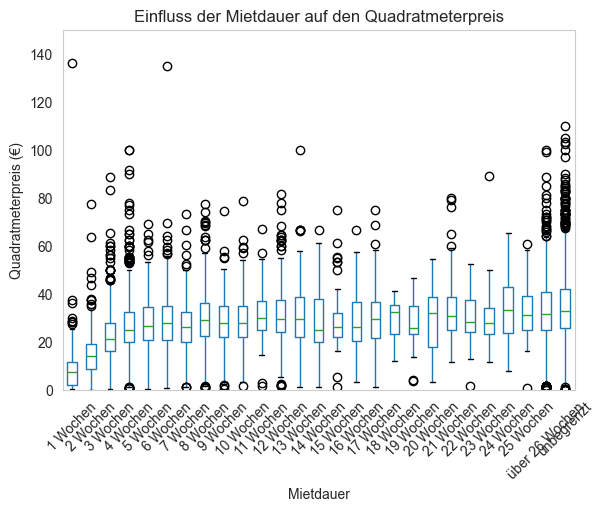

In [288]:
plt.figure(figsize=(12, 6))
df.boxplot(column='price_per_m2', by='duration_category', grid=False)
plt.title('Einfluss der Mietdauer auf den Quadratmeterpreis')
plt.xlabel('Mietdauer')
plt.ylabel('Quadratmeterpreis (€)')
plt.xticks(rotation=45)
plt.ylim(0, 150)
plt.suptitle('')
plt.show()


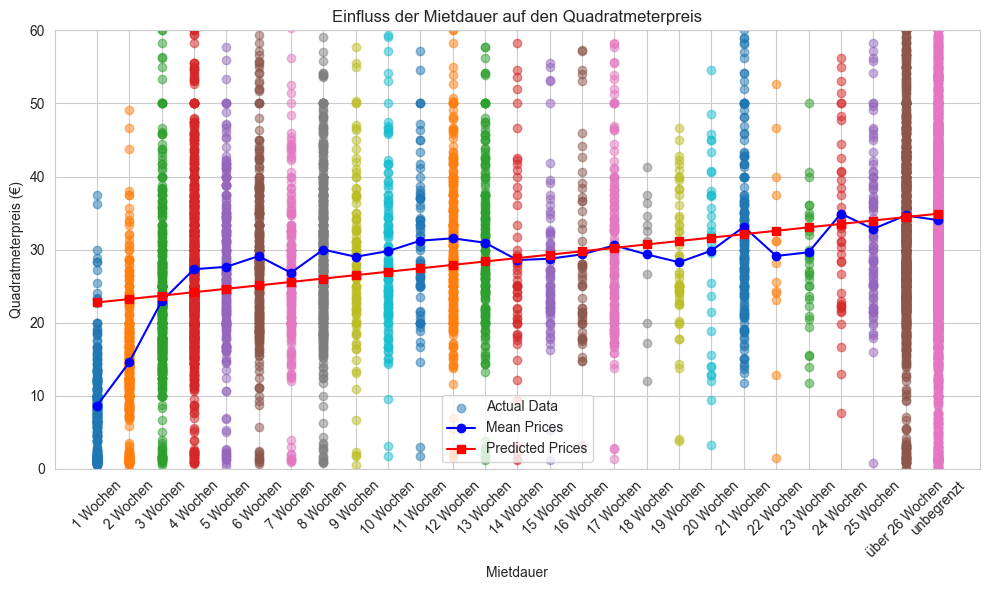

In [289]:
# Reinige die Kategorien von NaN-Werten
df['duration_category'].fillna("unbegrenzt", inplace=True)

# Berechnung des Quadratmeterpreises
df['price_per_m2'] = pd.to_numeric(df['total_rent'], errors='coerce') / pd.to_numeric(df['room_size'], errors='coerce')
df.dropna(subset=['price_per_m2'], inplace=True)

# Umwandlung der kategorisierten Mietdauer in numerische Werte für die Regression
df['duration_numeric'] = df['duration_category'].astype('category').cat.codes

# Daten für das Modell vorbereiten
X = sm.add_constant(df[['duration_numeric']])  # Fügt eine Konstante (Intercept) zum Modell hinzu
Y = df['price_per_m2']

# Modell erstellen und anpassen
model = sm.OLS(Y, X).fit()

# Vorhersagen für jede Kategorie machen
df['predicted'] = model.predict(X)

# Visualization
plt.figure(figsize=(10, 6))
categories = df['duration_category'].cat.categories
means = df.groupby('duration_category')['price_per_m2'].mean()
predicted = df.groupby('duration_category')['predicted'].mean()

# Ensure categories are used in the plot
for category in categories:
    actual = df[df['duration_category'] == category]['price_per_m2']
    plt.scatter([category] * len(actual), actual, alpha=0.5, label='Actual Data' if category == categories[0] else "")
plt.plot(categories, [means[cat] for cat in categories], 'o-', color='blue', label='Mean Prices')
plt.plot(categories, [predicted[cat] for cat in categories], 's-', color='red', label='Predicted Prices')

plt.title('Einfluss der Mietdauer auf den Quadratmeterpreis')
plt.xlabel('Mietdauer')
plt.ylabel('Quadratmeterpreis (€)')
plt.xticks(rotation=45)
plt.ylim(0, 60)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Step 2.4: Furnishing and Square Meter Price 

In [290]:
df = df_price_det_analysis.copy()

# Bereinigen der 'furnitured' Spalte
df['furnitured'] = df['furnitured'].map({'möbliert': 1, 'teilmöbliert': 0.5}).fillna(0)

# Dummy-Variablen für 'balcony' und 'garden' (nehmen an, dass NaN als '0' behandelt wird)
df['balcony'] = df['balcony'].fillna(0)
df['garden'] = df['garden'].fillna(0)
df['bathroom'] = df['bathroom'].fillna('')

# Behandlung der 'bathroom' Spalte
df['has_shower'] = df['bathroom'].str.contains('Dusche').astype(int)
df['has_bathtub'] = df['bathroom'].str.contains('Badewanne').astype(int)
df['has_private_bath'] = df['bathroom'].str.contains('Eigenes Bad').astype(int)

# Bereinigung der Zielvariable
df['price_per_m2'] = pd.to_numeric(df['price_per_m2'], errors='coerce')
df.dropna(subset=['price_per_m2'], inplace=True)

# Vorbereiten der unabhängigen Variablen X
X_columns = ['furnitured', 'balcony', 'garden', 'has_shower', 'has_bathtub', 'has_private_bath']
X = sm.add_constant(df[X_columns])  # Konstante hinzufügen für das Intercept

# Abhängige Variable Y
Y = df['price_per_m2']

# Daten aufteilen in Trainings- und Testdatensätze
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Modell erstellen und anpassen
model = sm.OLS(y_train, X_train).fit()

# Ergebnisse ausgeben
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     43.90
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           6.54e-53
Time:                        15:41:00   Log-Likelihood:                -28585.
No. Observations:                6690   AIC:                         5.718e+04
Df Residuals:                    6683   BIC:                         5.723e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               28.9938      0.465  

Model Summary:

- Dep. Variable: price_per_m2
- R-squared (0.038): This value indicates that only about 3.8% of the variability in the square meter price is explained by the model, which suggests that these features alone do not strongly predict square meter price.
- Adjusted R-squared (0.037): This is very close to the R-squared, reinforcing that the model explains only a small fraction of the variance in square meter prices.
- F-statistic (43.90): Indicates the model is statistically significant overall, suggesting that at least some of the explanatory variables significantly affect square meter prices.
- Prob (F-statistic) (6.54e-53): This confirms that the model is statistically significant at a general level.


Coefficients Interpretation:
- const (28.9938): This is the expected square meter price when all other variables are zero (basic level without additional amenities or features).
- furnitured (-0.4829, p=0.321): Surprisingly, being furnished or partly furnished does not statistically significantly increase the square meter price and has a negative coefficient, suggesting it might decrease the price or is not as valued, contrary to what might be expected. This result is not statistically significant.
- balcony (1.6011, p=0.001): Apartments with balconies tend to have higher square meter prices, significantly affecting the price by an average of about 1.6011 units more than apartments without balconies.
- garden (3.2253, p<0.001): Having a garden has a more substantial positive effect, significantly increasing the square meter price by about 3.2253 units.
- has_shower (0.8292, p=0.059) and has_bathtub (0.8719, p=0.047): Both having a shower and a bathtub show positive effects on the square meter price, with bathtubs having a significant effect at the 5% level, indicating a marginal preference for bathtubs over mere showers.
- has_private_bath (-10.1721, p<0.001): Surprisingly, having a private bath significantly decreases the square meter price, which might suggest issues like overfitting or data misinterpretations (or that private baths might be associated with other less desirable apartment traits in the data).

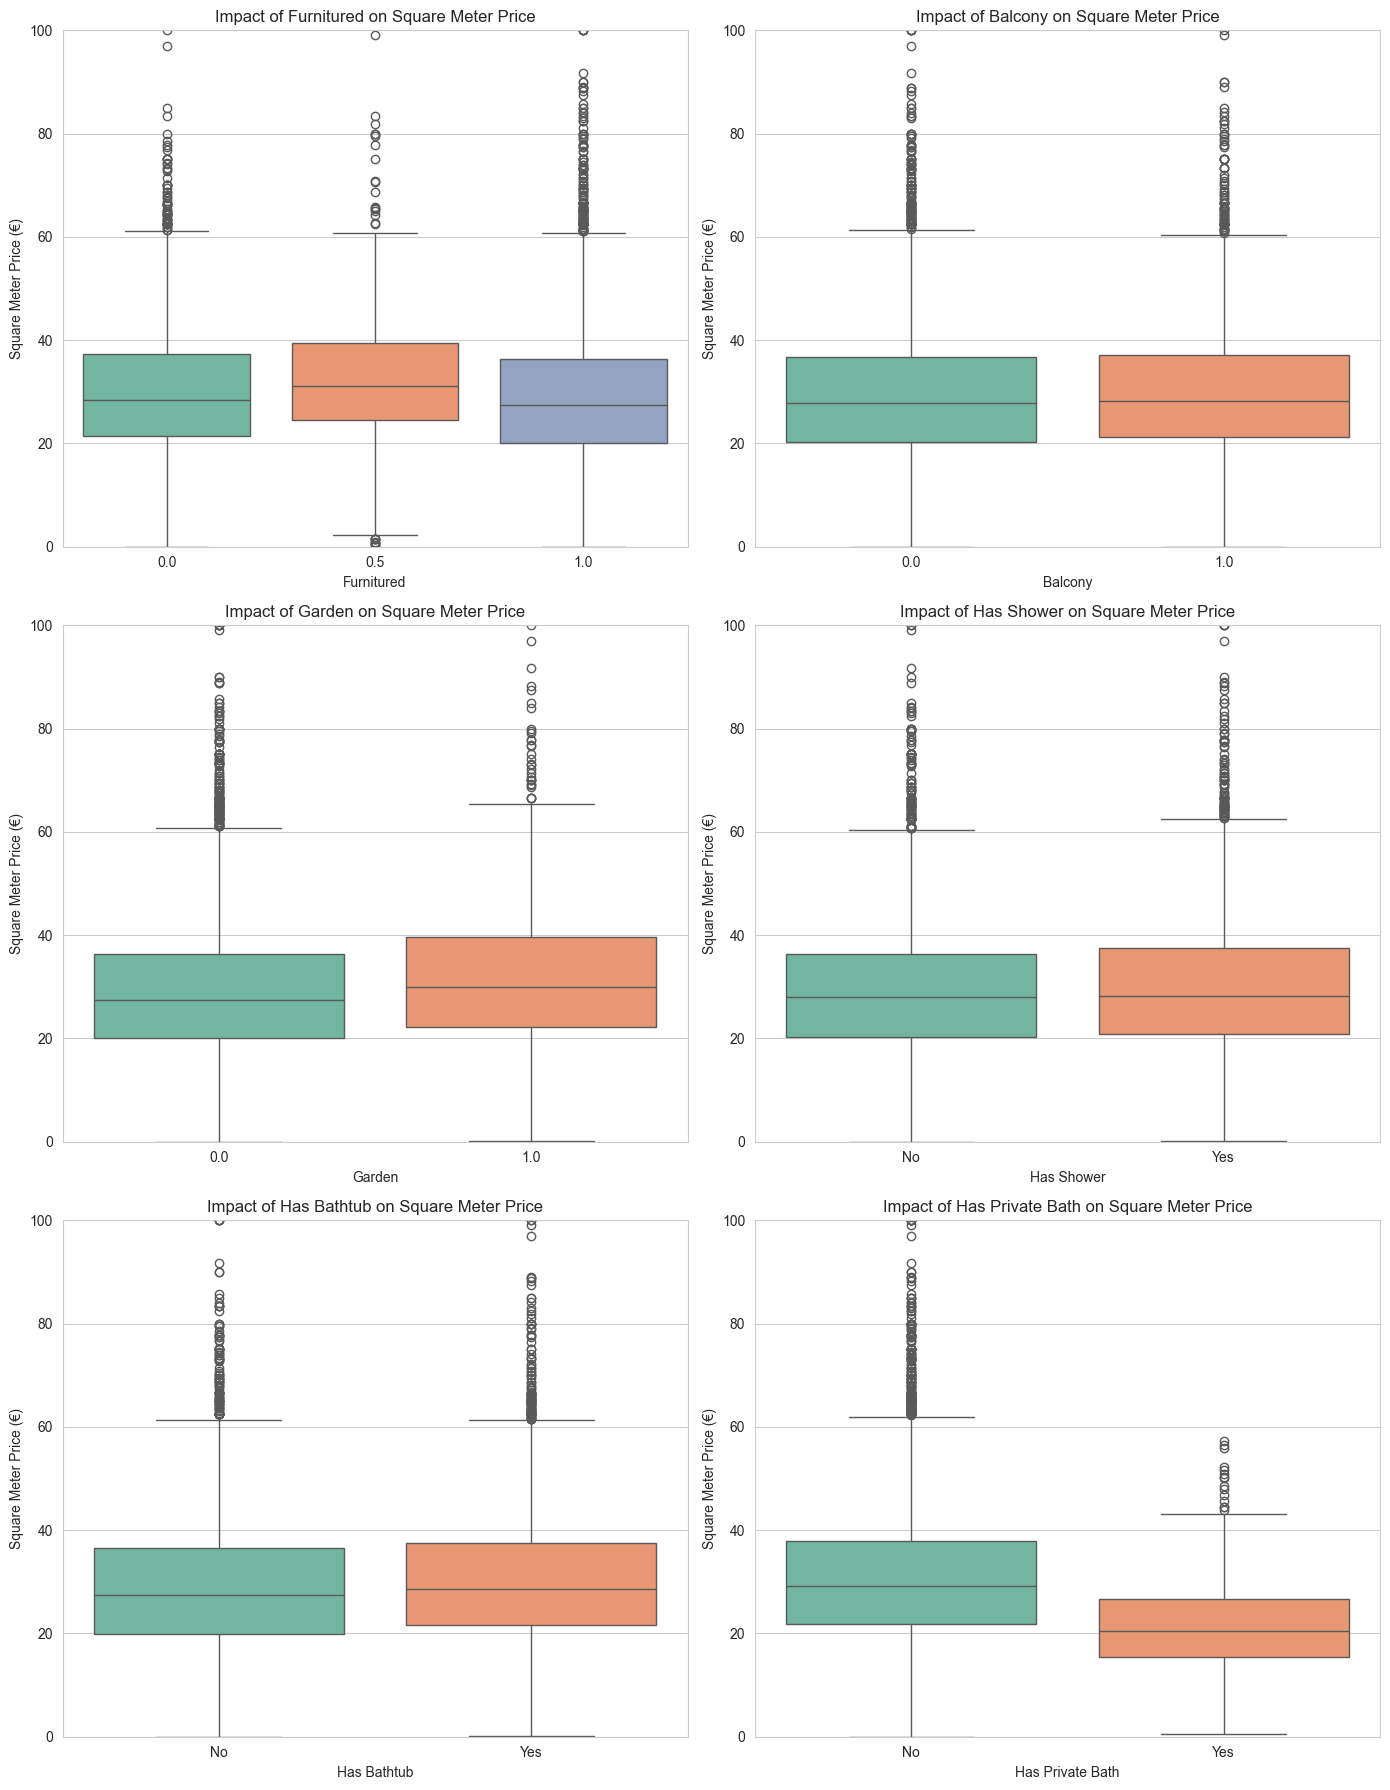

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Data setup for plotting
amenities = ['furnitured', 'balcony', 'garden', 'has_shower', 'has_bathtub', 'has_private_bath']
data_for_plot = df[amenities + ['price_per_m2']]

# Create a figure to hold subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, amenity in enumerate(amenities):
    # Create a boxplot for each amenity
    sns.boxplot(x=amenity, y='price_per_m2', data=data_for_plot, ax=axes[i], palette="Set2")
    axes[i].set_title(f'Impact of {amenity.replace("_", " ").title()} on Square Meter Price')
    axes[i].set_xlabel(amenity.replace('_', ' ').title())
    axes[i].set_ylabel('Square Meter Price (€)')
    axes[i].set_ylim(0, 100) 
    # Improve x-axis labels for binary features
    if data_for_plot[amenity].dtype == 'int':
        axes[i].set_xticklabels(['No', 'Yes'])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
